In [1]:
#picaso
import picaso.opacity_factory as opa_fa
from picaso import justdoit as jdi
from picaso import justplotit as jpi
#plotting
from bokeh.io import output_notebook

output_notebook()
from bokeh.plotting import show,figure

Loading BokehJS ...

In [2]:
wave_range = [0.4,2]

opa = jdi.opannection(wave_range=wave_range)

In [4]:
case1 = jdi.inputs()
case1.phase_angle(phase=60*np.pi/180, num_tangle=6, num_gangle=6)
case1.gravity(gravity=20 , gravity_unit=u.Unit('m/s**2'))
case1.atmosphere(filename = jdi.jupiter_pt(), delim_whitespace=True)
case1.star(opa, 5000,0,4.0)
df = case1.spectrum(opa, calculation='reflected' ,full_output=True)

<Figure size 800x600 with 0 Axes>

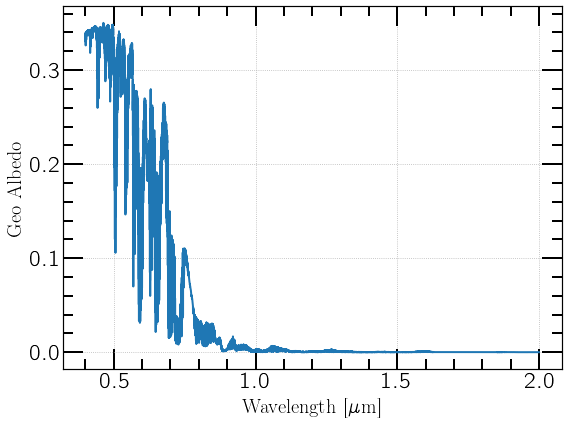

In [6]:
x,y = df['wavenumber'], df['albedo']
plt.figure()
plt.figure(figsize=(8,6))
plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =20, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.plot(1e4/x, y, lw=2)

plt.gca().set_xlabel(r'Wavelength [$\mu$m]')
plt.gca().set_ylabel('Geo Albedo')
plt.grid(ls=':')
plt.tight_layout()

In [9]:
case1 = jdi.inputs()
case1.phase_angle(phase=60*np.pi/180, num_tangle=6, num_gangle=6)
case2 = jdi.inputs()
case2.phase_angle(0)
case3 = jdi.inputs()
case3.phase_angle(phase=60*np.pi/180, num_tangle=10, num_gangle=10)
cases = [case1, case2, case3]
for i in cases:i.gravity(gravity=20 , gravity_unit=u.Unit('m/s**2'))
for i in cases:i.atmosphere(filename = jdi.jupiter_pt(), delim_whitespace=True)
for i in cases:i.star(opa, 5000,0,4.0)

import time
names = ['6x6_60','1x10','10x10_60']
df = {}
for i,ikey in zip(cases, names):
    start = time.time()
    df[ikey] = i.spectrum(opa,calculation='reflected' ,full_output=True)
    stop = time.time()
    print(ikey, stop-start)

6x6_60 14.545583963394165
1x10 3.3034088611602783
10x10_60 43.017767906188965


In [10]:
to_compare = []
fraction_compare = []
for ikey in names:
    x,y = df[ikey]['wavenumber'], df[ikey]['albedo']
    x,y = jdi.mean_regrid(x, y, R=100) #wavenumber, erg/cm2/s/Hz
    df[ikey]['regridy'] =  y
    df[ikey]['regridx'] = x
    to_compare += [df[ikey]['regridy']]

show(jpi.spectrum([x]*len(to_compare),to_compare, legend=names
                  ,plot_width=800))

6x6_60


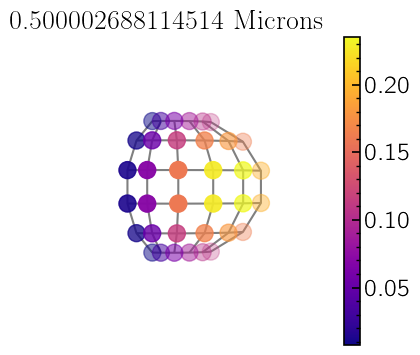

1x10


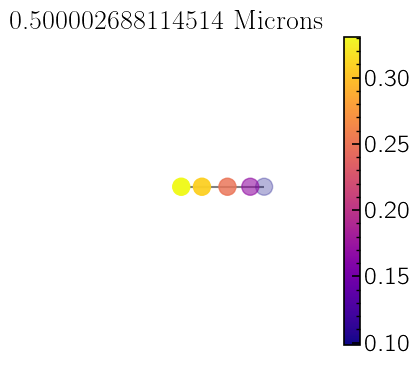

10x10_60


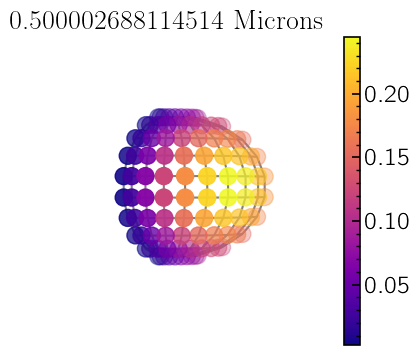

In [11]:
for ikey in names:
    asdict = df[ikey]['full_output']
    print(ikey)
    jpi.disco(asdict, calculation='reflected', wavelength=[0.5])

In [15]:
phases = [0,30,45,60,90,120,135,140,160,170]
cases = []

for i in range(len(phases)):
    case = jdi.inputs()
    case.phase_angle(phase=phases[i]*np.pi/180, num_tangle=6, num_gangle=6)
    case.gravity(gravity=20 , gravity_unit=u.Unit('m/s**2'))
    case.atmosphere(filename = jdi.jupiter_pt(), delim_whitespace=True)
    case.star(opa, 5000,0,4.0)
    cases.append(case)

import time
names = [str(phase) for phase in phases]
df = {}
for i,ikey in zip(cases, names):
    start = time.time()
    df[ikey] = i.spectrum(opa,calculation='reflected' ,full_output=True)
    stop = time.time()
    print(ikey, stop-start)

0 17.214042901992798
30 15.252986907958984
45 15.873836994171143
60 15.662183046340942
90 15.700148105621338
120 15.84183406829834
135 15.362955808639526
140 15.247550010681152
160 15.356000185012817
170 15.331410884857178


In [16]:
to_compare = []
fraction_compare = []
for ikey in names:
    x,y = df[ikey]['wavenumber'], df[ikey]['albedo']
    x,y = jdi.mean_regrid(x, y, R=100) #wavenumber, erg/cm2/s/Hz
    df[ikey]['regridy'] =  y
    df[ikey]['regridx'] = x
    to_compare += [df[ikey]['regridy']]

show(jpi.spectrum([x]*len(to_compare),to_compare, legend=names
                  ,plot_width=800))

In [8]:
savefiledirectory = '../modeling/ReflectXGasGiantModelGrid-Neptune-Tstar3000-Rstar0.2-Teq187.1302769665348-sep0.1-rad0.35-mass0.05-mh100-co0.5-phase0'
pdict, sdict, cdict = pickle.load(open(savefiledirectory+'/cloud-free-model-inputs.pkl','rb'))

In [11]:
from myastrotools.tijuca import *
def MakeModelCloudFreePlanet(pdict, sdict,
                calculation = "planet",
                use_guillotpt = True,
                user_supplied_ptprofile = None,
                cdict = None,
                climate_pbottom = 2,
                climate_ptop = -6,
                compute_spectrum = True,
                specdict = None,
                savefiledirectory = None
             ):
    
    ''' Wrapper for PICASO functions for building a planet model
    Args:
        pdict (dict): dictionary of planet parameter inputs
        sdict (dict): dictionary of star parameter inputs
        opacity_db (jdi.opannection object)
        calculation (str): picaso input for object, "planet" or "brown dwarf"
        use_guillotpt (bool): if True, use Guillot PT approximation. Else user must supply initial PT profile
        user_supplied_ptprofile (df): user supplied pt profile for picaso
        cdict (dict): dictionary of climate run setup params
        climate_pbottom (flt): log(pressure) at bottom of climate calc
        climate_ptop (flt): log(pressure) at top of climate calc
        molecules (list): list of molecules to compute cloud properties. If None, use virga recommended mols
        savemodel (bool): if true, save the model using the xarray method in picaso
        savefilename (str): filename and path for the model to be saved.
    Returns:
        pl: picaso planet model inputs
        noclouds: picaso object after climate run before clouds
    '''
    import warnings
    warnings.filterwarnings('ignore')
    import picaso.justdoit as jdi
    
    import sys
    import os
    
    # retrieve opacity correlated k-tables database:
    PlanetMH = pdict['mh']
    PlanetCO = ConvertCtoOtoStr(pdict['CtoO'])
    PlanetMHStr = ConvertPlanetMHtoCKStr(pdict['planet_mh_str'])

    #ck_db = f'/Volumes/Oy/picaso/reference/kcoeff_2020/sonora_2020_feh{PlanetMH}_co_{PlanetCO}.data.196'
    if pdict['noTiOVO']:
        ck_db_name = pdict['local_ck_path'] + f'sonora_2020_feh{PlanetMHStr}_co_{PlanetCO}_noTiOVO.data.196'
    else:
        ck_db_name = pdict['local_ck_path'] + f'sonora_2020_feh{PlanetMHStr}_co_{PlanetCO}.data.196'
    print(ck_db_name)
    
    opacity_ck = jdi.opannection(ck_db=ck_db_name)
    
    # initialize model:
    pl = jdi.inputs(calculation= calculation, climate = True)
    
    # set up planet:
    # input effective temperature
    pl.effective_temp(pdict['tint']) 
    # add gravity:
    if not pdict['gravity']:
        pl.gravity(radius=pdict['radius'], radius_unit=pdict['radius_unit'], 
            mass = pdict['mass'], mass_unit=pdict['mass_unit'])
    else:
        pl.gravity(gravity=pdict['gravity'], gravity_unit=pdict['gravity_unit'])
        
    # set up star:
    pl.star(opacity_ck, temp = sdict['Teff'], metal = np.log10(sdict['mh']), logg = sdict['logg'], 
            radius = sdict['radius'], radius_unit = u.R_sun, 
            semi_major = pdict['semi_major'], semi_major_unit = pdict['semi_major_unit'], database = 'phoenix')
    
    phase = pdict['phase']
    # If full phase:
    if phase == 0:
        # Use symmetry to speed up calculation.
        num_tangle = 1
        pdict['num_tangle'] = 1
    else:
        num_tangle = pdict['num_tangle']
        
    pl.phase_angle(phase=phase*np.pi/180, num_tangle=num_tangle, num_gangle=pdict['num_gangle'])
    
    # climate run
    if use_guillotpt:
        pt = pl.guillot_pt(pdict['Teq'], nlevel=cdict['nlevel'], T_int = pdict['tint'], 
                              p_bottom=climate_pbottom, p_top=climate_ptop)
    else:
        pt = user_supplied_ptprofile

    # initial PT profile guess:
    temp_guess = pt['temperature'].values 
    press_guess = pt['pressure'].values
    # Input climate params:
    nstr = np.array([0,cdict['nstr_upper'],cdict['nstr_deep'],0,0,0]) # initial guess of convective zones
    pl.inputs_climate(temp_guess= temp_guess, pressure= press_guess, 
                  nstr = nstr, nofczns = cdict['nofczns'] , rfacv = cdict['rfacv'])
    print('starting climate run')
    # Compute climate:
    noclouds = pl.climate(opacity_ck, save_all_profiles=True, with_spec=True)
    pl.atmosphere(df=noclouds['ptchem_df'])
    
    return pl, noclouds
    
pl, noclouds = MakeModelCloudFreePlanet(pdict, sdict,
                calculation = "planet",
                use_guillotpt = True,
                user_supplied_ptprofile = None,
                cdict = cdict,
                climate_pbottom = 2,
                climate_ptop = -6,
                compute_spectrum = True,
                specdict = None,
                savefiledirectory = None)

/Volumes/Oy/picaso/reference/kcoeff_2020/sonora_2020_feh+200_co_050_noTiOVO.data.196
NOTE: You are loading Opacity tables without any Gaseous TiO and VO opacities
starting climate run
Iteration number  0 , min , max temp  165.43192499428577 794.3210148857679 , flux balance  0.9835032311193999
Iteration number  1 , min , max temp  174.1017265172362 1319.513196264218 , flux balance  0.9728555007737765
Iteration number  2 , min , max temp  182.76695540062408 1383.7788518430934 , flux balance  0.9731266917624525
Iteration number  3 , min , max temp  192.93260386901184 1471.4524671950428 , flux balance  1.0616914402046747
Iteration number  4 , min , max temp  183.87593396507114 1597.8915981994346 , flux balance  2.0577448116438632
Iteration number  5 , min , max temp  178.58470004739144 1565.476778207496 , flux balance  0.11679212635061693
Iteration number  6 , min , max temp  178.35760191630573 1560.943262802015 , flux balance  0.0008834911958308482
Iteration number  7 , min , max temp  17

Iteration number  0 , min , max temp  181.1200950030979 1776.1423729857372 , flux balance  1.6614409193597318e-05
Iteration number  1 , min , max temp  181.12006166711703 1776.1428214704674 , flux balance  6.639938809628677e-09
In t_start: Converged Solution in iterations  1
Profile converged
[ 0 66 73 73 85 89]
Iteration number  0 , min , max temp  181.4712985417661 1775.7605085931305 , flux balance  -0.22083846987426328
Iteration number  1 , min , max temp  182.14528332994044 1775.0089325271003 , flux balance  0.012624797922962033
Iteration number  2 , min , max temp  182.121199257603 1775.030779219131 , flux balance  5.402626764595716e-05
Iteration number  3 , min , max temp  182.12109463561512 1775.0313971741762 , flux balance  2.2978373933582594e-08
In t_start: Converged Solution in iterations  3
Big iteration is  182.12109463561512 0
Iteration number  0 , min , max temp  181.92879364315502 1774.9281752049123 , flux balance  0.016171475834483976
Iteration number  1 , min , max tem

Iteration number  0 , min , max temp  184.79090329557727 1130.2802824838586 , flux balance  0.00032234949621516654
Iteration number  1 , min , max temp  184.79007199105732 1130.2220209557115 , flux balance  1.6871922624824494e-06
In t_start: Converged Solution in iterations  1
Profile converged
[ 0 63 89  0 85 89]
Iteration number  0 , min , max temp  184.87073049682573 1094.7077085657008 , flux balance  0.0009440024846297387
Iteration number  1 , min , max temp  184.86881635852455 1094.5570129107268 , flux balance  8.038203105866637e-06
In t_start: Converged Solution in iterations  1
Big iteration is  184.86881635852455 0
Iteration number  0 , min , max temp  184.9467808791965 1098.72602172478 , flux balance  -1.1486457369061564e-05
In t_start: Converged Solution in iterations  0
Profile converged
[ 0 62 89  0 85 89]
Iteration number  0 , min , max temp  184.9833118699647 1098.6433217221988 , flux balance  -7.812699993440626e-05
In t_start: Converged Solution in iterations  0
Big iter

In [14]:
PlanetCO = ConvertCtoOtoStr(pdict['CtoO'])
PlanetMHStr = ConvertPlanetMHtoCKStr(pdict['planet_mh_str'])
ck_db_name = pdict['local_ck_path'] + f'sonora_2020_feh{PlanetMHStr}_co_{PlanetCO}_noTiOVO.data.196'
opacity_ck = jdi.opannection(ck_db=ck_db_name)
df = pl.spectrum(opacity_ck, calculation='reflected', full_output=True)

NOTE: You are loading Opacity tables without any Gaseous TiO and VO opacities


AttributeError: 'RetrieveCKs' object has no attribute 'unshifted_stellar_spec'

In [ ]:
opa_mon = jdi.opannection(wave_range=[0.4,2.0])

In [16]:
spec = jdi.inputs(calculation="planet") # start a calculation
spec.phase_angle(phase=pdict['phase']*np.pi/180, num_tangle=pdict['num_tangle'], num_gangle=pdict['num_gangle'])
if not pdict['gravity']:
    spec.gravity(radius=pdict['radius'], radius_unit=pdict['radius_unit'], 
        mass = pdict['mass'], mass_unit=pdict['mass_unit'])
else:
    spec.gravity(gravity=pdict['gravity'], gravity_unit=pdict['gravity_unit'])

# set up star:
spec.star(opa_mon, temp = sdict['Teff'], metal = np.log10(sdict['mh']), logg = sdict['logg'], 
        radius = sdict['radius'], radius_unit = u.R_sun, 
        semi_major = pdict['semi_major'], semi_major_unit = pdict['semi_major_unit'], database = 'phoenix')

spec.atmosphere(df=noclouds['ptchem_df'])
spec_df = spec.spectrum(opa_mon, 
                        calculation='reflected', 
                        full_output=True)
w,f = jdi.mean_regrid(spec_df['wavenumber'],
                      spec_df['fpfs_reflected'], R=150)

Turning off Raman for Non-H2 atmosphere
